### Proyecto 1: RL en vehiculo 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import time
import matplotlib.pyplot as plt
import pandas as pd


# Estos vienen del curso de coursera
import h5py
import tensorflow as tf
from tensorflow.python.framework import ops

## Class to create static objects



In [37]:
class static_obstacle:
    
    num_obs = 0

    def __init__(self, name, pos_x, pos_y, color):   
        self.name   = name
        self.pos_x  = pos_x
        self.pos_y  = pos_y
        self.color  = color
        static_obstacle.num_obs += 1
   
    def displayCount(self):
        print (static_obstacle.num_obs)
        

    def displayObstacle(self):
          print ("Name : ", self.name,  ", Coordenate in x: ", self.pos_x, ", Coordenate in y: ", self.pos_y, ", Color: ", self.color)




In [42]:
a = static_obstacle('car1',2,-5,'red')
b = static_obstacle('car2',1,-2,'blue')
c = static_obstacle('car3',0, 0 , 'nero')
a.color = 'geen'
a.displayObstacle()

Name :  car1 , Coordenate in x:  2 , Coordenate in y:  -5 , Color:  geen


## Action Selector

La funcion para seleccionar acciones, abajo esta comentada la funcion para generar enteros aleatorios.

In [2]:
def action(num,sT):


# add a hard constraint of 6 degrees per sec on the steering angle rate of change.

    if num == 0:   
    #muy a la izquierda
        a = -(np.pi/30)*sT
    elif num == 1:    
        #Medio a la izquierda   
        a = -(np.pi/60)*sT
    elif num == 2:
    # No angulo
        a = 0
    elif num == 3:  
        #medio a la derecha
        a = (np.pi/60)*sT  
    elif num == 4:
        # muy a la derecha
        a = (np.pi/60)*sT

    return a


###print (np.random.randint(5, size=(1)))

## Parameters

Funcion para seleccionar acciones al azar

In [3]:
#def parametros_car(): 

m = 1575
I_z = 2875
L_f = 1.2
L_dr = 1.6
C_f = 19000
C_dr = 33000
    
parametros_car = {'m': m ,'I_z': I_z, 'L_f': L_f, 'L_dr' : L_dr, 'C_f' : C_f, 'C_dr' : C_dr}

#    return parametros_car

## Time

Se definen los valores de tiempo de inicio, tiempo final y tiempo de muestreo

In [4]:
#Valores del tiempo y muestreo
ti = 0
tf = 30
sT = .01

c = int((tf-ti)/sT)

t = np.linspace(ti,tf,c,endpoint=False)
t = np.reshape(t,(t.shape[0],1))

print (t.shape)

(3000, 1)


### Dictionary with the systems states (initial states)

In [5]:
def init_states(v_x0, v_y0, r_0, x_g0, Y_g0, theta0, t):

    v_y = np.zeros(t.shape)
    r = np.zeros(t.shape)
    X_g = np.zeros(t.shape)
    Y_g = np.zeros(t.shape)
    theta = np.zeros(t.shape)

    v_x = v_x0
    v_y[0] = v_y0
    r [0] = r_0
    X_g[0] = x_g0
    Y_g[0]= Y_g0
    theta[0] = theta0


    X_states={'v_x': v_x ,'v_y': v_y, 'r': r, 'X_g' : X_g, 'Y_g' : Y_g, 'theta' : theta}
    
    return X_states

## Target

In [6]:
def target(reward, gamma, Q_next):
    
    target = reward + gamma * Q_next
    
    
    return target

### Cost Function

In [7]:
def cost(target, Q_actual):
    """
    Computes the cost for deep Q learning  
    
    Returns:
    cost -- runs the session of the cost (formula (2))
    """
    
    ### START CODE HERE ### 
    
    # Create the placeholders 
    y = tf.placeholder(tf.float32, name = "y")
    y_hat = tf.placeholder(tf.float32, name = "y_hat")
    
    # Use the loss function 
    #cost = tf.nn.sigmoid_cross_entropy_with_logits(labels= y, logits= z)
    cost = tf.losses.mean_squared_error(labels = target, predictions = y_hat )
    
    # Create a session (approx. 1 line). See method 1 above.
    sess = tf.Session()
    
    # Run the session (approx. 1 line).
    cost = sess.run(cost, feed_dict= {y_hat : Q_actual , y : target})
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
        
    return cost

### Vehicle Model

In [8]:
def car_model(X_states, parametros_car, action, t):

        df = action
        i = t
    
        v_x   = X_states['v_x']
        v_y   = X_states['v_y']
        r     = X_states['r']
        X_g   = X_states['X_g']
        Y_g   = X_states['Y_g']
        theta = X_states['theta']
        
        m    =  parametros_car['m']
        I_z  = parametros_car['I_z']
        L_f  = parametros_car['L_f']
        L_dr = parametros_car['L_dr']
        C_f  = parametros_car['C_f']
        C_dr = parametros_car['C_dr']

        

        a_f = v_y[i] + (L_f * r[i]) / v_x - d_f #Slip angle fdront
        a_dr = v_y[i] - (L_dr * r[i]) / v_x

        Fyf = -C_f * a_f
        Fydr = -C_dr * a_dr

        dv_y = (Fyf / m) * np.cos(d_f) + (Fydr/m) - v_x * r[i]
        dr   = (L_f / I_z) * (Fyf) * np.cos(d_f) - (L_dr / I_z) * Fydr

        # Cambio de coordenadas



        dX_g = (v_x * np.cos(theta[i]) - v_y[i] * np.sin(theta[i]))
        dY_g =(v_x * np.sin(theta[i]) + v_y[i] * np.cos(theta[i]))
        dtheta = r[i]

        v_y[i+1]  =v_y[i] + sT * dv_y
        r[i+1] = r[i] + sT * dr
        X_g[i+1] =X_g[i] + sT * dX_g
        Y_g[i+1] = Y_g[i] + sT * dY_g
        theta[i+1] = theta[i] + sT * dtheta
    
        X_states={'v_x': v_x ,'v_y': v_y, 'r': r, 'X_g' : X_g, 'Y_g' : Y_g, 'theta' : theta}
    
        return X_states
    
#     if  i % 100 == 0:
#         plt.plot(X_g[i],Y_g[i],'*')


### Test for the model

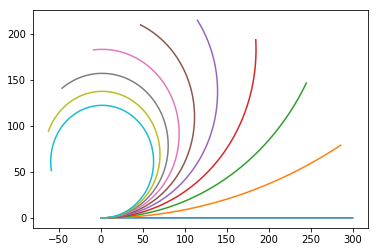

In [9]:
X_states = init_states(v_x0 = 10 , v_y0 = 0 , r_0 = 0 , x_g0 = 0, Y_g0 = 0, theta0 = 0, t = t)


for episodes in range(10):
    d_f = 0.01 * episodes
    for i in range(len(t) -1 ):
        X_states = car_model(X_states, parametros_car, action = d_f, t = i)
        
            
            

    plt.plot(X_states['X_g'],X_states['Y_g'])
    